## Weather Data : Visualization After Smoothing

### For New York State

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
import pyspark.sql
sqlContext = SQLContext(sc)

import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

_figsize=(10,7)

## Read Data

### Read Raw data for state

In [9]:
!rm -r ../Data/Weather/WA.*
!ls ../Data/Weather

decon_WA_PRCP_s20.parquet  NY.tgz	     STAT_WA.pickle	US_stations.tsv
NY.parquet		   stations.parquet  STAT_WA.pickle.gz


In [10]:
state='WA'
data_dir='../Data/Weather'

tarname=state+'.tgz'
parquet=state+'.parquet'

!rm -rf $data_dir/$tarname

command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s > %s/%s"%(tarname,data_dir,tarname)
print(command)
!$command
!ls -lh $data_dir/$tarname

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/WA.tgz > ../Data/Weather/WA.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 61.4M  100 61.4M    0     0  18.8M      0  0:00:03  0:00:03 --:--:-- 18.8M
-rw-rw-r-- 1 fanjin fanjin 62M May  6 21:59 ../Data/Weather/WA.tgz


In [11]:
!ls -l $data_dir

total 178612
drwxrwxr-x 2 fanjin fanjin     4096 May  6 21:32 decon_WA_PRCP_s20.parquet
drwxrwxr-x 2 fanjin fanjin     4096 Apr 18 18:12 NY.parquet
-rw-rw-r-- 1 fanjin fanjin 66288146 May  6 21:07 NY.tgz
drwxr-xr-x 2 fanjin fanjin     4096 Apr 10 14:22 stations.parquet
-rw-rw-r-- 1 fanjin fanjin 51366605 May  6 21:32 STAT_WA.pickle
-rw-rw-r-- 1 fanjin fanjin      305 May  6 21:37 STAT_WA.pickle.gz
-rw-rw-r-- 1 fanjin fanjin   731305 May  6 21:37 US_stations.tsv
-rw-rw-r-- 1 fanjin fanjin 64485728 May  6 21:59 WA.tgz


In [14]:
cur_dir,=!pwd
%cd $data_dir
!tar -xzf $tarname
!du -h ./$parquet
%cd $cur_dir

/home/fanjin/Works/CSE255-DSE230-2018/Sections/Data/Weather
75M	./WA.parquet
/home/fanjin/Works/CSE255-DSE230-2018/Sections/Section2-Weather-PCA


In [15]:
# !du -h $data_dir/$parquet

In [16]:
print(parquet)
weather_df=sqlContext.read.parquet(data_dir+'/'+parquet)
#weather_df=weather_df.drop('State') # we drop State because it already exists in "Stations".
print('number of rows=',weather_df.count())

WA.parquet
number of rows= 177336


In [17]:
weather_df.show(1)

+-----------+-----------+----+--------------------+-----------------+-----------------+-------------------+-----------------+-----+----------+
|    Station|Measurement|Year|              Values|       dist_coast|         latitude|          longitude|        elevation|state|      name|
+-----------+-----------+----+--------------------+-----------------+-----------------+-------------------+-----------------+-----+----------+
|USC00459342|       PRCP|1901|[00 7E 00 7E 00 7...|126.7229995727539|45.79999923706055|-121.93329620361328|351.1000061035156|   WA|WIND RIVER|
+-----------+-----------+----+--------------------+-----------------+-----------------+-------------------+-----------------+-----+----------+
only showing top 1 row



### read statistics information for state.

In [18]:
#read statistics
filename='STAT_%s.pickle'%state
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s.gz > %s/%s.gz"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/STAT_WA.pickle.gz > ../Data/Weather/STAT_WA.pickle.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32.0M  100 32.0M    0     0  13.9M      0  0:00:02  0:00:02 --:--:-- 13.9M


In [19]:
gzpath='%s/%s.gz'%(data_dir,filename)
print(gzpath)
!ls -l $gzpath

../Data/Weather/STAT_WA.pickle.gz
-rw-rw-r-- 1 fanjin fanjin 33572191 May  6 21:59 ../Data/Weather/STAT_WA.pickle.gz


In [20]:
print(gzpath)
!gunzip $gzpath
!ls -l $data_dir

../Data/Weather/STAT_WA.pickle.gz
gzip: ../Data/Weather/STAT_WA.pickle already exists; do you wish to overwrite (y or n)? ^C
total 211404
drwxrwxr-x 2 fanjin fanjin     4096 May  6 21:32 decon_WA_PRCP_s20.parquet
drwxrwxr-x 2 fanjin fanjin     4096 Apr 18 18:12 NY.parquet
-rw-rw-r-- 1 fanjin fanjin 66288146 May  6 21:07 NY.tgz
drwxr-xr-x 2 fanjin fanjin     4096 Apr 10 14:22 stations.parquet
-rw-rw-r-- 1 fanjin fanjin 51366605 May  6 21:32 STAT_WA.pickle
-rw-rw-r-- 1 fanjin fanjin 33572191 May  6 21:59 STAT_WA.pickle.gz
-rw-rw-r-- 1 fanjin fanjin   731305 May  6 21:37 US_stations.tsv
drwxrwxr-x 2 fanjin fanjin     4096 Apr 18 18:13 WA.parquet
-rw-rw-r-- 1 fanjin fanjin 64485728 May  6 21:59 WA.tgz


In [22]:
STAT,STAT_Descriptions = load(open(data_dir+'/'+filename,'rb'))


In [23]:
Measurements = STAT.keys()
Measurements

dict_keys(['TMAX_s20', 'SNWD_s20', 'TMIN_s20', 'SNWD', 'TMAX', 'PRCP_s20', 'SNOW', 'TOBS_s20', 'SNOW_s20', 'TMIN', 'TOBS', 'PRCP'])

In [24]:
print("   Name  \t                 Description             \t  Size")
print("-"*80)
print('\n'.join(["%10s\t%40s\t%s"%(s[0],s[1],str(s[2])) for s in STAT_Descriptions]))

   Name  	                 Description             	  Size
--------------------------------------------------------------------------------
SortedVals	                        Sample of values	vector whose length varies between measurements
     UnDef	      sample of number of undefs per row	vector whose length varies between measurements
      mean	                              mean value	()
       std	                                     std	()
    low100	                               bottom 1%	()
   high100	                                  top 1%	()
   low1000	                             bottom 0.1%	()
  high1000	                                top 0.1%	()
         E	                   Sum of values per day	(365,)
        NE	                 count of values per day	(365,)
      Mean	                                    E/NE	(365,)
         O	                   Sum of outer products	(365, 365)
        NO	               counts for outer products	(365, 365)
       Cov	                

### Read information about US weather stations.

In [25]:
filename='Weather_Stations.tgz'
parquet='stations.parquet'
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/%s > %s/%s"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/Weather_Stations.tgz > ../Data/Weather/Weather_Stations.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  344k  100  344k    0     0   461k      0 --:--:-- --:--:-- --:--:--  461k


In [26]:
%cd $data_dir
!tar -xzf $filename
!du -s *.parquet
%cd $cur_dir

/home/fanjin/Works/CSE255-DSE230-2018/Sections/Data/Weather
77828	NY.parquet
76116	WA.parquet
12756	decon_WA_PRCP_s20.parquet
420	stations.parquet
/home/fanjin/Works/CSE255-DSE230-2018/Sections/Section2-Weather-PCA


In [27]:
stations_df =sqlContext.read.parquet(data_dir+'/'+parquet)
stations_df.show(5)

+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|State|            Name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00341900|   739.956|    36.3| -96.4667|    242.3|   OK|       CLEVELAND|
|USC00428114|    908.22|    40.1|-111.6667|   1409.1|   UT|SPANISH FORK 1 S|
|USC00165926|   23.8801| 29.7853| -90.1158|      0.9|   LA|   MARRERO 9 SSW|
|USC00411974|   541.905| 31.5333|-101.2842|    755.9|   TX|        COPE RCH|
|USC00318906|   310.311| 35.5231| -81.4439|    274.3|   NC|    VALE AG 2 SW|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 5 rows



In [28]:
weather_df.join?

In [29]:
jdf=weather_df.drop('name').join(stations_df,on='Station',how='left')
jdf.show(3)

+-----------+-----------+----+--------------------+-----------------+-----------------+-------------------+-----------------+-----+----------+--------+---------+---------+-----+----------+
|    Station|Measurement|Year|              Values|       dist_coast|         latitude|          longitude|        elevation|state|Dist_coast|Latitude|Longitude|Elevation|State|      Name|
+-----------+-----------+----+--------------------+-----------------+-----------------+-------------------+-----------------+-----+----------+--------+---------+---------+-----+----------+
|USC00459342|       PRCP|1901|[00 7E 00 7E 00 7...|126.7229995727539|45.79999923706055|-121.93329620361328|351.1000061035156|   WA|   126.723|    45.8|-121.9333|    351.1|   WA|WIND RIVER|
|USC00459342|       PRCP|1906|[00 7E 00 7E 00 7...|126.7229995727539|45.79999923706055|-121.93329620361328|351.1000061035156|   WA|   126.723|    45.8|-121.9333|    351.1|   WA|WIND RIVER|
|USC00459342|       PRCP|1907|[00 7E 00 7E 00 7...|126.

In [30]:
sqlContext.registerDataFrameAsTable(jdf,'jdf')

#find the stations in NY with the most measurements.
sqlContext.sql('select Name,count(Name) as count from jdf GROUP BY Name ORDER BY count DESC').show(5)

+------------+-----+
|        Name|count|
+------------+-----+
|     PROSSER| 1612|
|     ROSALIA| 1428|
|   OLGA 2 SE| 1424|
|   SUNNYSIDE| 1422|
|DAYTON 1 WSW| 1410|
+------------+-----+
only showing top 5 rows



In [54]:
#find how many measurements of each type for a particlar station
stat='WILBUR'
Query="""
SELECT Measurement,count(Measurement) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Measurement
"""%stat
sqlContext.sql(Query).show()

+-----------+-----+
|Measurement|count|
+-----------+-----+
|   TMIN_s20|  117|
|       TMIN|  117|
|   SNOW_s20|  116|
|       TOBS|  114|
|   SNWD_s20|   70|
|   TOBS_s20|  114|
|   PRCP_s20|  117|
|       TMAX|  117|
|       SNOW|  116|
|   TMAX_s20|  117|
|       SNWD|   70|
|       PRCP|  117|
+-----------+-----+



In [68]:
#find year with all 6 measurements
Query="""
SELECT Year,count(Year) as count 
FROM jdf 
WHERE Name='%s'
GROUP BY Year
ORDER BY count DESC
"""%stat
sqlContext.sql(Query).show(5)

+-----------+-----------+----+--------------------+-----------------+-----------------+-------------------+-----------------+-----+----------+--------+---------+---------+-----+----------+
|    Station|Measurement|Year|              Values|       dist_coast|         latitude|          longitude|        elevation|state|Dist_coast|Latitude|Longitude|Elevation|State|      Name|
+-----------+-----------+----+--------------------+-----------------+-----------------+-------------------+-----------------+-----+----------+--------+---------+---------+-----+----------+
|USC00459342|       PRCP|1901|[00 7E 00 7E 00 7...|126.7229995727539|45.79999923706055|-121.93329620361328|351.1000061035156|   WA|   126.723|    45.8|-121.9333|    351.1|   WA|WIND RIVER|
|USC00459342|       PRCP|1906|[00 7E 00 7E 00 7...|126.7229995727539|45.79999923706055|-121.93329620361328|351.1000061035156|   WA|   126.723|    45.8|-121.9333|    351.1|   WA|WIND RIVER|
|USC00459342|       PRCP|1907|[00 7E 00 7E 00 7...|126.

In [67]:
#find year with all 6 measurements
Query="""
SELECT * 
FROM jdf 
WHERE Name='%s' AND Year > 2000
GROUP BY Year
ORDER BY count DESC
"""%stat
sqlContext.show(5)

AttributeError: 'SQLContext' object has no attribute 'show'

In [56]:
# get all measurements for a particular year and a particular station
year=2007
Query="""
SELECT *
FROM jdf 
WHERE Name='%s' 
and Year=%d
"""%(stat,year )
pandas_df=sqlContext.sql(Query).toPandas()
pandas_df=pandas_df.set_index('Measurement')
pandas_df

,Station,Year,Values,dist_coast,latitude,longitude,elevation,state,Dist_coast,Latitude,Longitude,Elevation,State,Name
Measurement,,,,,,,,,,,,,,
SNOW_s20,USC00459238,2007,"[13, 78, 207, 77, 148, 77, 87, 77, 60, 77, 2, ...",264.244995,47.756699,-118.677498,686.700012,WA,264.244995,47.756699,-118.677498,686.700012,WA,WILBUR
TOBS_s20,USC00459238,2007,"[61, 209, 72, 209, 81, 209, 91, 209, 99, 209, ...",264.244995,47.756699,-118.677498,686.700012,WA,264.244995,47.756699,-118.677498,686.700012,WA,WILBUR
SNWD_s20,USC00459238,2007,"[40, 83, 249, 82, 209, 82, 169, 82, 126, 82, 8...",264.244995,47.756699,-118.677498,686.700012,WA,264.244995,47.756699,-118.677498,686.700012,WA,WILBUR
PRCP_s20,USC00459238,2007,"[209, 79, 143, 79, 83, 79, 19, 79, 250, 78, 18...",264.244995,47.756699,-118.677498,686.700012,WA,264.244995,47.756699,-118.677498,686.700012,WA,WILBUR
TMAX_s20,USC00459238,2007,"[46, 61, 47, 60, 91, 58, 157, 56, 41, 53, 235,...",264.244995,47.756699,-118.677498,686.700012,WA,264.244995,47.756699,-118.677498,686.700012,WA,WILBUR
TMIN_s20,USC00459238,2007,"[142, 212, 149, 212, 155, 212, 160, 212, 165, ...",264.244995,47.756699,-118.677498,686.700012,WA,264.244995,47.756699,-118.677498,686.700012,WA,WILBUR
PRCP,USC00459238,2007,"[0, 126, 0, 126, 0, 126, 0, 126, 0, 126, 0, 12...",264.244995,47.756699,-118.677498,686.700012,WA,264.244995,47.756699,-118.677498,686.700012,WA,WILBUR
SNOW,USC00459238,2007,"[0, 126, 0, 126, 0, 126, 0, 126, 0, 126, 0, 12...",264.244995,47.756699,-118.677498,686.700012,WA,264.244995,47.756699,-118.677498,686.700012,WA,WILBUR
SNWD,USC00459238,2007,"[0, 126, 0, 126, 0, 126, 0, 126, 0, 126, 0, 12...",264.244995,47.756699,-118.677498,686.700012,WA,264.244995,47.756699,-118.677498,686.700012,WA,WILBUR


## Plots

In [34]:
raw_measurements=[m for m in Measurements if not '_s20' in m]
raw_measurements

['SNWD', 'TMAX', 'SNOW', 'TMIN', 'TOBS', 'PRCP']

KeyError: 'the label [SNWD] is not in the [index]'

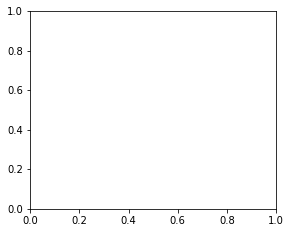

In [35]:
figure(figsize=[15,8])
i=1
for m in raw_measurements:
    subplot(2,3,i)
    i+=1
    if m=='PRCP' or m=='SNOW':
        f=20
    else:
        f=1
    plot(unpackArray(pandas_df.loc[m,'Values'],np.float16)/10.,label=m);
    ms=m+"_s20"
    
    plot(f*unpackArray(pandas_df.loc[ms,'Values'],np.float16)/10.,label=ms);
    xlabel('day of year')
    title(m)
    legend()
    grid()

In [36]:
from lib.YearPlotter import *
from lib.MultiPlot import *
YP=YearPlotter()
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m,label=m)
    

### Plots of mean and std of observations

In [37]:
def plot_mean_std(m,fig,axis):
    scale=1.
    temps=['TMIN','TMAX','TOBS']
    percipitation=['PRCP','SNOW','SNWD']
    _labels=['mean+std','mean','mean-std']
    if (m in temps or m=='PRCP'):
        scale=10.
    mean=STAT[m]['Mean']/scale
    std=np.sqrt(STAT[m]['Var'])/scale
    graphs=np.vstack([mean+std,mean,mean-std]).transpose()
    YP.plot(graphs,fig,axis,labels=_labels,title='Mean+-std   '+m)
    if (m in temps):
        axis.set_ylabel('Degrees Celsius')
    if (m in percipitation):
        axis.set_ylabel('millimeter')



In [38]:
from lib.MultiPlot import *

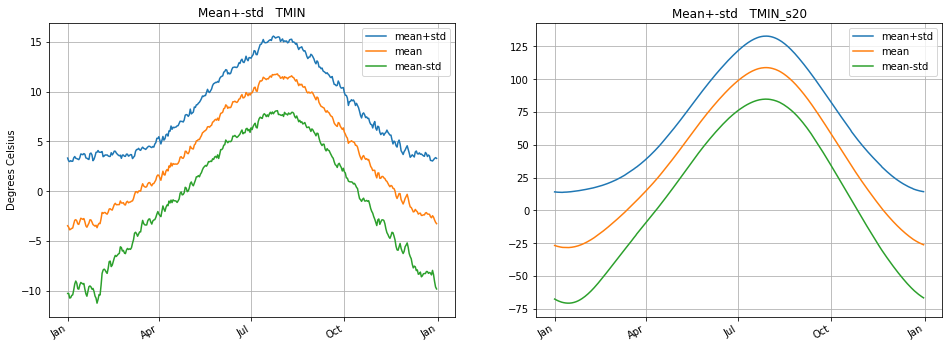

In [39]:
plot_pair(['TMIN','TMIN_s20'],plot_mean_std)

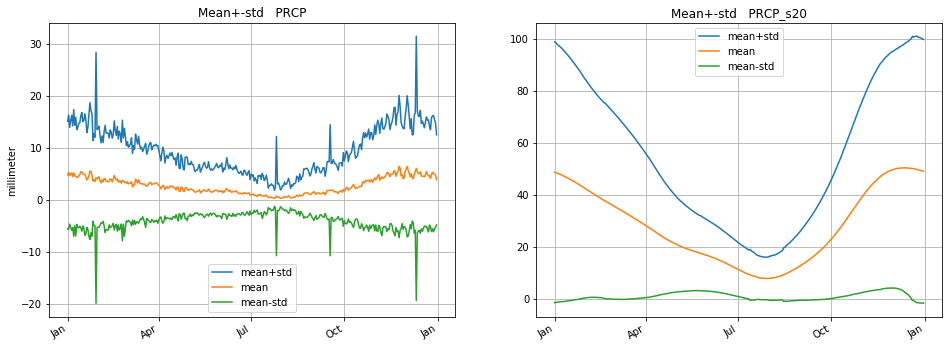

In [52]:
plot_pair(['PRCP','PRCP_s20'],plot_mean_std)

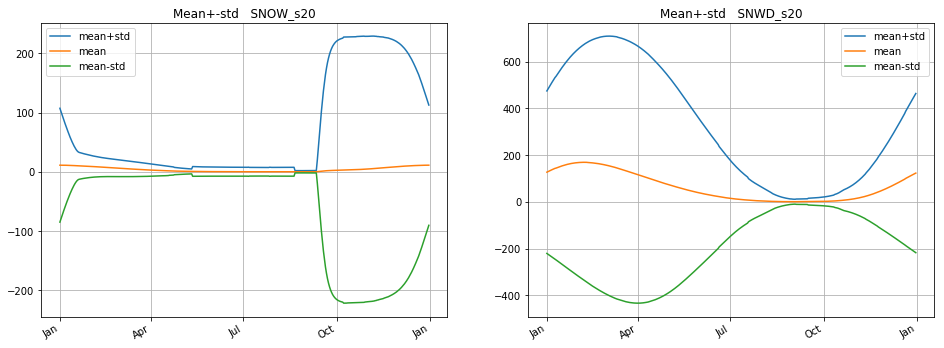

In [41]:
plot_pair(['SNOW_s20', 'SNWD_s20'],plot_mean_std)

### Plotting percentage of variance explained by Eigen-vectors

In [42]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    L=([0,]+list(cumsum(EV[:k])))/sum(EV)
    #print m,L
    plot(L)
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

In [43]:
# create a subdirectory in which to place the plots.
!mkdir r_figures

mkdir: cannot create directory ‘r_figures’: File exists


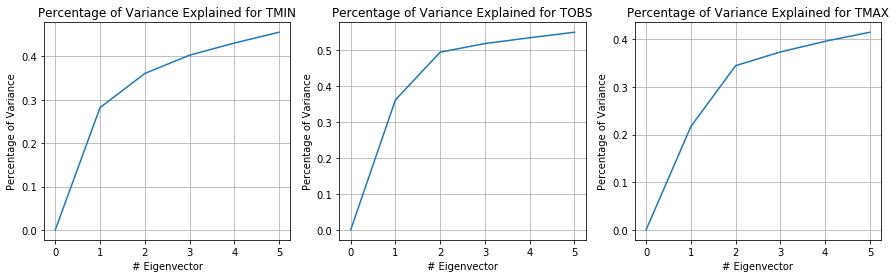

In [44]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1
f.savefig('r_figures/VarExplained1.png')

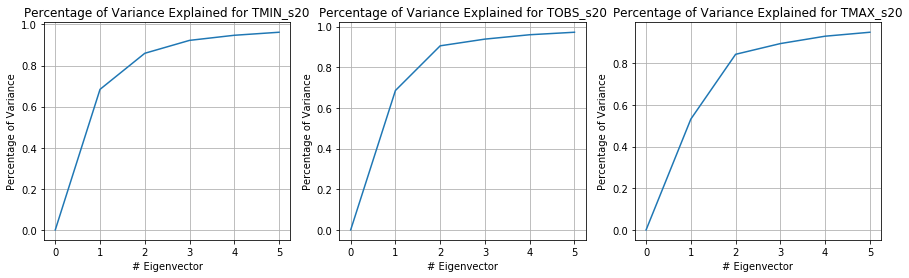

In [45]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN_s20', 'TOBS_s20', 'TMAX_s20']: #,
    pltVarExplained(j)
    j+=1
f.savefig('r_figures/VarExplained1.png')

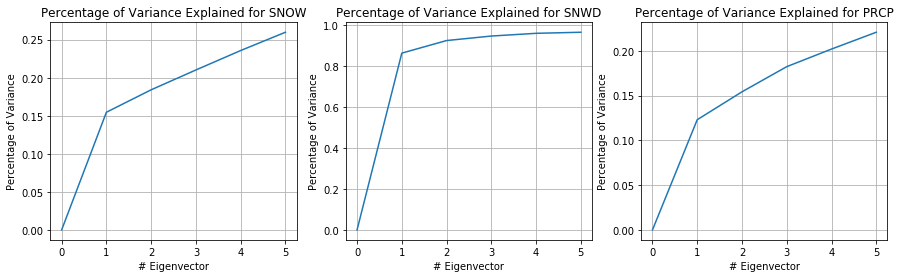

In [46]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 
f.savefig('r_figures/VarExplained2.png') 

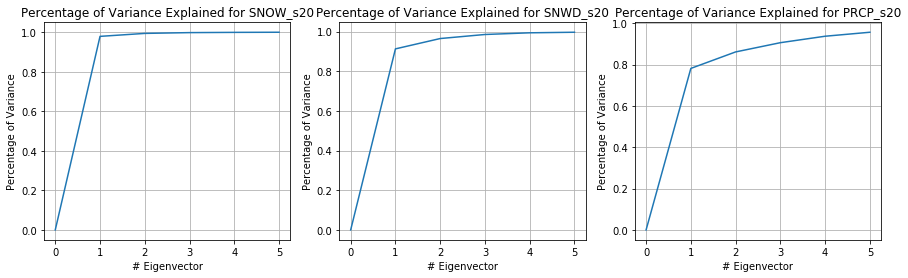

In [47]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW_s20', 'SNWD_s20', 'PRCP_s20']:
    pltVarExplained(j)
    j+=1 
f.savefig('r_figures/VarExplained2.png') 

### plotting top 3 eigenvectors

In [48]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

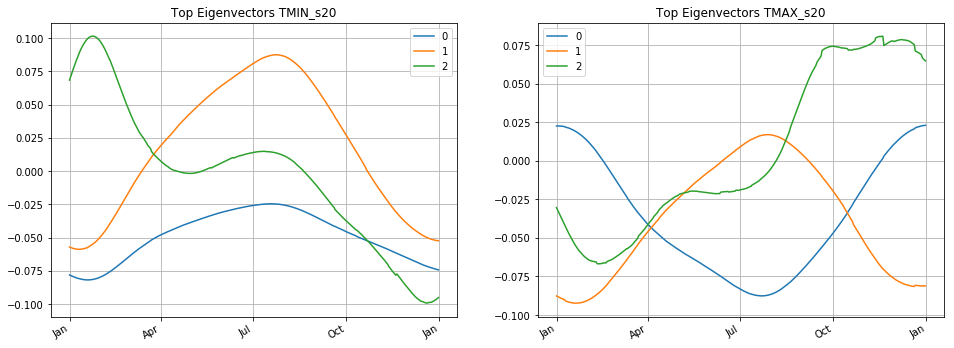

In [49]:
plot_pair(['TMIN_s20','TMAX_s20'],plot_eigen)

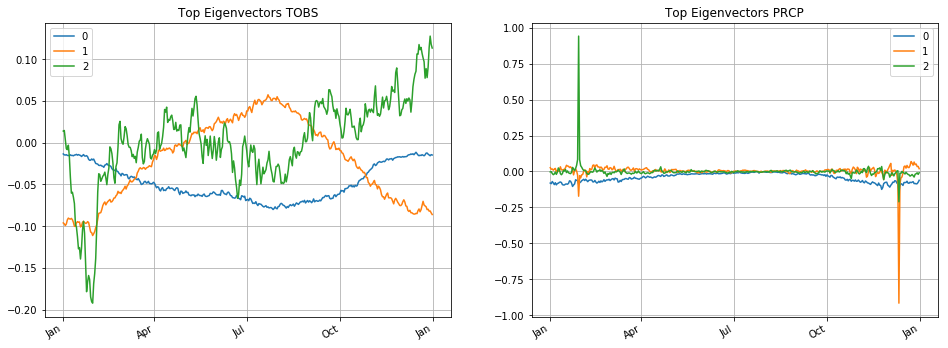

In [71]:
plot_pair(['TOBS','PRCP'],plot_eigen)

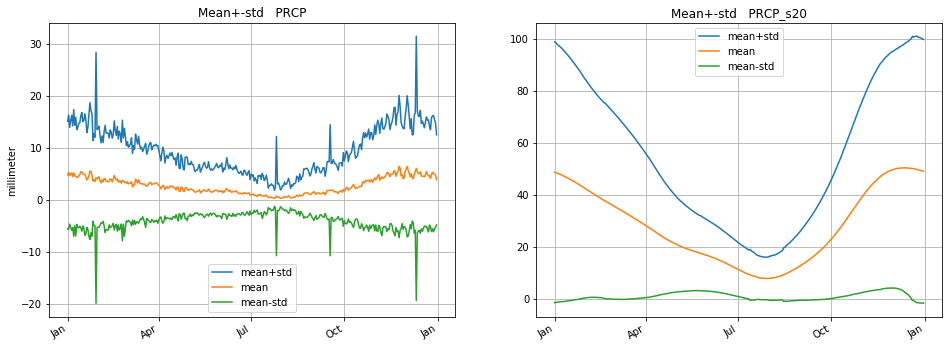

In [72]:
plot_pair(['PRCP','PRCP_s20'],plot_mean_std)

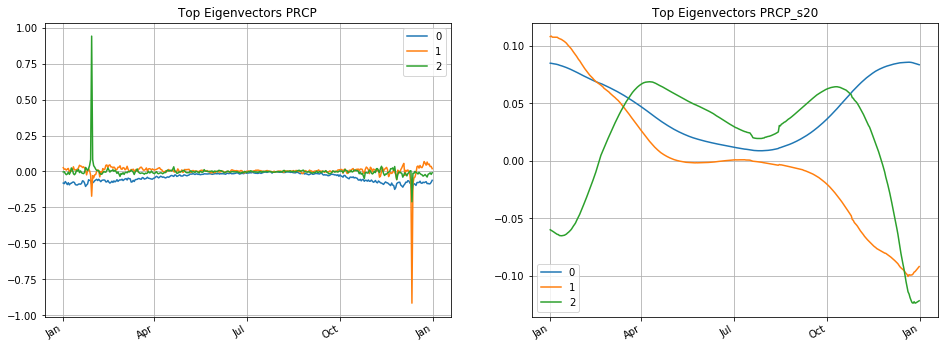

In [73]:
plot_pair(['PRCP','PRCP_s20'],plot_eigen)

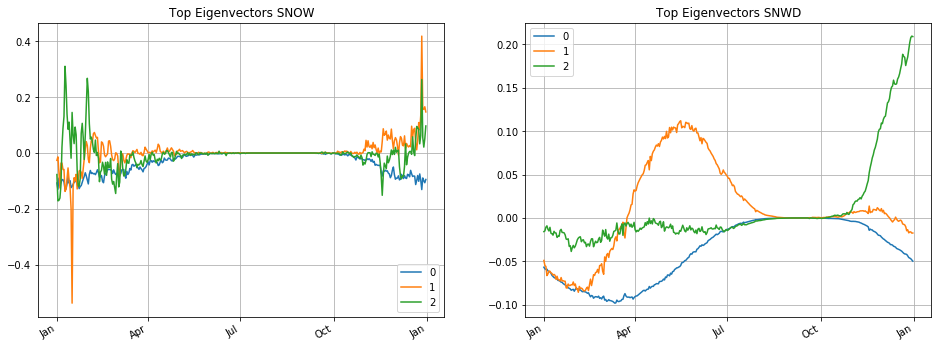

In [51]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

## Summary
We saw how to plot:
* Data from several (Station,Year,Measurement)
* The mean+-std for a particular (Station,Measurement)
* The percentage of cariance explained by top eigen-vectors.
* The top eigen-vectors